In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2 # preprocessing images
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # for progress bars and est. time

In [2]:
labels = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)
labels.head(6)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [3]:
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")
labels.head(6)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0


In [4]:
ROOT_PATH = Path("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("/kaggle/working/Processed/")

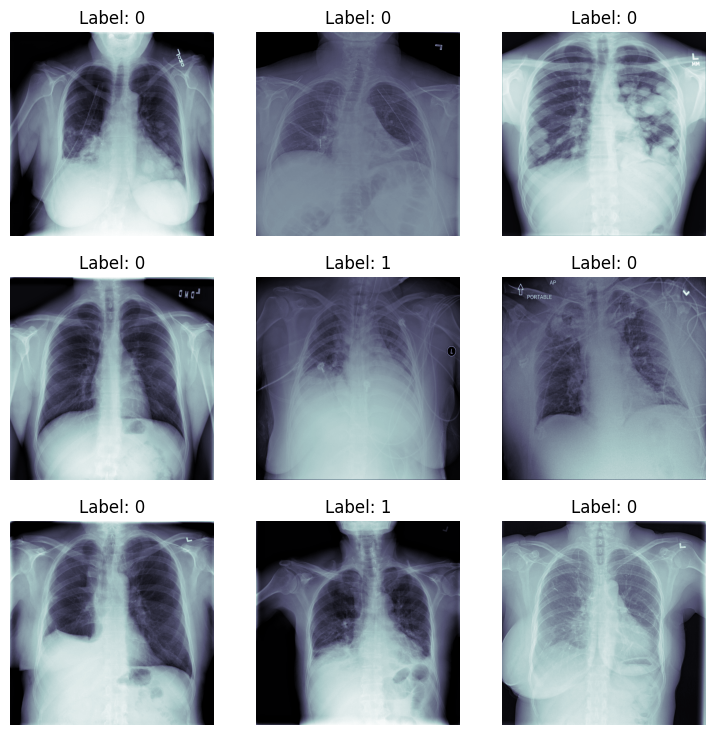

In [5]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        
        # Full path to DICOM file
        dcm_path = ROOT_PATH / f"{patient_id}.dcm"
        
        # Read and extract pixel array
        dcm = pydicom.dcmread(dcm_path).pixel_array
        
        # Get label
        label = labels["Target"].iloc[c]
        
        # Show image
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(f"Label: {label}")
        axis[i][j].axis("off")
        
        c += 1

In [6]:
import gc

sums = 0
sums_squared = 0

# Loop over all patients
for c, patient_id in enumerate(tqdm(labels.patientId)):
    # Decide train/val folder
    train_or_val = "train" if c < 24000 else "val"
    label = labels.Target.iloc[c]
    
    # Path where this patient's file should be saved
    current_save_path = SAVE_PATH / train_or_val / str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    save_file = current_save_path / f"{patient_id}.npy"
    
    # Skip if file already exists (resume mode)
    if save_file.exists():
        continue
    
    # Read the DICOM file and normalize
    dcm_path = ROOT_PATH / f"{patient_id}.dcm"
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255.0
    
    # Resize to 224x224 and convert to float16 to save space
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    # Update sums for mean/std calculation
    sums += dcm_array.mean()
    sums_squared += (dcm_array ** 2).mean()
    
    # Save file
    np.save(save_file, dcm_array)
    
    # Clear memory every 1000 images
    if c % 1000 == 0:
        gc.collect()

print("Processing complete!")

  0%|          | 0/26684 [00:00<?, ?it/s]

Processing complete!
